In [1]:
import numpy as np
import codecs
import collections
import random
from nltk.tokenize import word_tokenize

from keras import backend as K
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, LSTM, Dropout

Using TensorFlow backend.


In [2]:
word_freq = collections.Counter()
def load_data(fpath, wf):
    data = []
    with codecs.open(fpath, 'r', 'utf-8', errors='ignore') as f:
        lines = f.readlines()
        for l in lines:
            label, words = l.strip().split('\t', 1)
            words = word_tokenize(words.encode().decode('ascii', 'ignore').lower())
            data.append((words, label))
            for w in words:
                word_freq[w] += 1
    return data
data = load_data('./training.txt', word_freq)

In [3]:
max_vocab = 2500
vocab_size = min(max_vocab, len(word_freq)) + 2
w2i = {w[0]:i for i, w in enumerate(word_freq.most_common(max_vocab), 2)}
PAD = '<PADDING>'
UNK = '<UNK>'
w2i[PAD], w2i[UNK] = 0, 1
i2w = {v:k for k, v in w2i.items()}

sentence_maxlen = max(map(len, (d for d, _ in data)))
print('sentence maxlen', sentence_maxlen)
print('vocab size', vocab_size)

sentence maxlen 42
vocab size 2315


In [4]:
# vectorize
N = len(data)
random.shuffle(data)
X = np.zeros((N, sentence_maxlen))
Y = np.zeros((N, ))
for i, (words, label) in enumerate(data):
    for t, w in enumerate(words):
        if w in w2i:
            X[i, t] = w2i[w]
        else:
            X[i, t] = w2i[UNK]
    Y[i] = label

In [5]:
# define model
embd_size = 128
hidden_size = 64
sentence_input = Input(shape=(None, ))
embd_sentence = Embedding(input_dim=vocab_size, output_dim=embd_size, input_length=sentence_maxlen)(sentence_input)
embd_sentence = Dropout(0.2)(embd_sentence)
out_rnn = LSTM(hidden_size, dropout=0.2, recurrent_dropout=0.2)(embd_sentence)
output = Dense(1, activation='sigmoid')(out_rnn)
model = Model(sentence_input, output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 42, 128)           296320    
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 345,793
Trainable params: 345,793
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
hist = model.fit(X, Y,
          batch_size=64,
          epochs=10,
          validation_split=.2)

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 3s 534us/step - loss: 0.0199 - acc: 0.9958 - val_loss: 0.0786 - val_acc: 0.9838
Epoch 2/10
5668/5668 [==============================] - 3s 534us/step - loss: 0.0279 - acc: 0.9951 - val_loss: 0.1003 - val_acc: 0.9831
Epoch 3/10
5668/5668 [==============================] - 3s 536us/step - loss: 0.0192 - acc: 0.9968 - val_loss: 0.0969 - val_acc: 0.9838
Epoch 4/10
5668/5668 [==============================] - 3s 538us/step - loss: 0.0129 - acc: 0.9981 - val_loss: 0.1040 - val_acc: 0.9831
Epoch 5/10
5668/5668 [==============================] - 3s 530us/step - loss: 0.0115 - acc: 0.9982 - val_loss: 0.1428 - val_acc: 0.9774
Epoch 6/10
5668/5668 [==============================] - 3s 532us/step - loss: 0.0289 - acc: 0.9958 - val_loss: 0.1155 - val_acc: 0.9810
Epoch 7/10
5668/5668 [==============================] - 3s 533us/step - loss: 0.0153 - acc: 0.9979 - val_loss: 0.1134 - val_acc: 0.9817


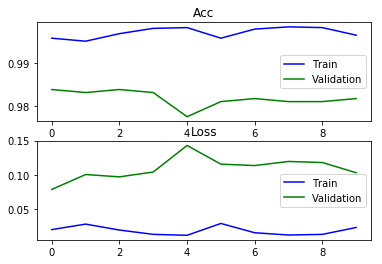

In [16]:
import matplotlib.pyplot as plt
ax1 = plt.subplot(211)
plt.title('Acc')
plt.plot(hist.history['acc'], color='b', label='Train')
plt.plot(hist.history['val_acc'], color='g', label='Validation')
# ax1.set_ylim([0.5, 1.])
plt.legend(loc='best')

ax2 = plt.subplot(212)
plt.title('Loss')
plt.plot(hist.history['loss'], color='b', label='Train')
plt.plot(hist.history['val_loss'], color='g', label='Validation')
# ax2.set_ylim([0., .5])
plt.legend(loc='best')

plt.show()